In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# MatplotlibおよびSeabornで日本語を表示可能にする
from matplotlib import rcParams
rcParams['font.family'] = 'MS Gothic'

# 高解像度なPNGでグラフを出力する
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

import tensorflow as tf
print("TensorFlow Version:", tf.__version__)

from flask import Flask
print("Flask導入された")

import pyopenjtalk
import pykakasi
from sudachipy import tokenizer, dictionary
import pyopenjtalk
from collections import defaultdict, Counter
import ast
import pickle



TensorFlow Version: 2.19.0
Flask導入された


In [3]:
# CSVを読み込む
df = pd.read_csv("dataset/processed_haiku.csv", encoding="utf-8")
print(df.head())
print(df.isnull().sum())

   ID           Haiku                                             Tokens  \
0   1      春も早山吹白く苣苦し  ['春/ハル/春/名詞', 'も/モ/も/助詞', '早い/ハヤイ/早い/形容詞', '山吹...   
1   2      山寺の春や仏に水仙花  ['山寺/ヤマデラ/山寺/名詞', 'の/ノ/の/助詞', '春/ハル/春/名詞', 'や/...   
2   3  門口に風呂たく春のとまりかな  ['門口/カドグチ/門口/名詞', 'に/ニ/に/助詞', '風呂/フロ/風呂/名詞', '...   
3   4   雪の絵を春も掛けたる埃かな  ['雪/ユキ/雪/名詞', 'の/ノ/の/助詞', '絵/エ/絵/名詞', 'を/ヲ/を/助...   
4   5  起重機の手挙げて立てり海は春  ['起重/キジュー/起重/名詞', '機/キ/機/名詞', 'の/ノ/の/助詞', '手/テ...   

                                            IDs  
0                  [10, 11, 12, 13, 14, 15, 16]  
1                  [17, 18, 10, 19, 20, 21, 22]  
2          [23, 21, 24, 25, 10, 18, 26, 27, 28]  
3  [29, 18, 30, 31, 10, 11, 32, 33, 34, 27, 28]  
4  [35, 36, 18, 37, 38, 39, 40, 41, 42, 43, 10]  
ID        0
Haiku     0
Tokens    0
IDs       0
dtype: int64


In [5]:
# word2id辞書を準備（出現頻度によるフィルタリングあり）

# すべてのトークンの出現頻度を集計
token_counter = Counter()
for idx, row in df.iterrows():
    tokens = ast.literal_eval(row['Tokens'])
    token_counter.update(tokens)

# 最小出現頻度を設定
min_freq = 3

# word2idを初期化
word2id = defaultdict(lambda: word2id["<UNK>"])
word2id["<PAD>"] = 0
word2id["<UNK>"] = 1
word2id["<START>"] = 2
word2id["<END>"] = 3

# 出現頻度が min_freq 以上の単語のみ追加
for token, freq in token_counter.items():
    if freq >= min_freq:
        word2id[token] = len(word2id)

print(f"語彙数（フィルタリング後）: {len(word2id)}")

# word2id保存
with open("dataset/word2id.pkl", "wb") as f:
    pickle.dump(dict(word2id), f)

# id2word保存
id2word = {v: k for k, v in word2id.items()}
with open("dataset/id2word.pkl", "wb") as f:
    pickle.dump(id2word, f)

語彙数（フィルタリング後）: 4370


In [7]:
# word2id を使って、分かち書きされた日本語の単語を ID に変換
haiku_ids_list = []
error_count = 0

for idx, row in df.iterrows():
    # 分かち書きの結果を順に処理
    tokens = ast.literal_eval(row['Tokens'])

    # ID のシーケンスに変換
    ids = [word2id[token] for token in tokens]
    haiku_ids_list.append(ids)

In [9]:
# 乱数シードの設定
np.random.seed(42)
tf.random.set_seed(42)

# モデルのパラメータ
vocab_size = len(word2id)
embedding_dim = 128      # 词嵌入维度
lstm_units = 128         # LSTM单元数
max_length = 16          # 最大序列长度

# 学習データの準備
def prepare_training_data(haiku_ids_list, max_length):
    X, y = [], []
    
    for haiku_ids in haiku_ids_list:
        # すべての俳句にSTARTとENDのトークンを追加
        sequence = [word2id["<START>"]] + haiku_ids + [word2id["<END>"]]
        
        # スライディングウィンドウでシーケンスを作成
        for i in range(1, len(sequence)):
            input_seq = sequence[:i]
            target = sequence[i]
            
            # 長さが16未満のシーケンスのみを処理
            if len(input_seq) <= max_length:
                X.append(input_seq)
                y.append(target)
    
    return X, y

X, y = prepare_training_data(haiku_ids_list, max_length)

print(f"訓練データ数: {len(X)}")
print(f"目標データ数: {len(y)}")

# データパディング
# シーケンスを同じ長さにパディング
print(f"シーケンスを指定した長さまでパディング {max_length}")
X_padded = pad_sequences(X, maxlen=max_length, padding='pre')
y_array = np.array(y)

print(X_padded.shape)
print(y_array.shape)

訓練データ数: 96696
目標データ数: 96696
シーケンスを指定した長さまでパディング 16
(96696, 16)
(96696,)


In [23]:
# モデルの作成
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    LSTM(lstm_units, return_sequences=True, dropout=0.3),
    LSTM(lstm_units, dropout=0.3),
    Dense(lstm_units, activation='relu'),
    Dropout(0.4),
    Dense(vocab_size, activation='softmax')
])

#　モデルの要約
model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 16, 128)        │     1,708,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 16, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13345)          │     1,721,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,709,345 (14.15 MB)

 Trainable params: 3,709,345 (14.15 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# 学習時の設定
# オプティマイザー : Adam
# 損失関数 : スパースカテゴリカルクロスエントロピー
# メトリック : 正解率(accuracy)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# 早期終了（過学習を防止するため）
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# モデルの自動保存（検証データで最も良いモデルのみを保存）
model_ckpt = ModelCheckpoint(
    filepath='model/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# 学習
epoch = 20
hist = model.fit(X_padded, y_array, epochs=epoch, batch_size=64, validation_split=0.1, callbacks=[early_stop, model_ckpt])


Epoch 1/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1587 - loss: 6.1784 
Epoch 1: val_loss improved from inf to 5.43387, saving model to model/best_model.keras
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.1588 - loss: 6.1781 - val_accuracy: 0.2496 - val_loss: 5.4339
Epoch 2/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2533 - loss: 5.2843 
Epoch 2: val_loss improved from 5.43387 to 5.32465, saving model to model/best_model.keras
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.2533 - loss: 5.2842 - val_accuracy: 0.2674 - val_loss: 5.3247
Epoch 3/20
1359/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2729 - loss: 5.1257 
Epoch 3: val_loss improved from 5.32465 to 5.28219, saving model to model/best_model.keras
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.2729 - loss: 5.1257 - val_accuracy: 0.2733 - val_loss: 5.2822
Epoch 4/20
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2802 - loss: 5.0171 
Epoch 4:

In [26]:
# モデルの保存
model.save("model/final_model.keras")

In [27]:
hist.history

{'accuracy': [0.20459403097629547,
  0.2615310251712799,
  0.2741364538669586,
  0.284443736076355,
  0.29557833075523376,
  0.30061131715774536,
  0.3046445846557617,
  0.30782753229141235,
  0.3116999566555023],
 'loss': [5.7605299949646,
  5.255831718444824,
  5.107606410980225,
  4.995981693267822,
  4.896250247955322,
  4.810482025146484,
  4.737768650054932,
  4.6707963943481445,
  4.608363628387451],
 'val_accuracy': [0.24963805079460144,
  0.2674250304698944,
  0.2733195424079895,
  0.2853153944015503,
  0.29296794533729553,
  0.28965872526168823,
  0.2883143723011017,
  0.2913133502006531,
  0.29079627990722656],
 'val_loss': [5.433870792388916,
  5.32465124130249,
  5.282186031341553,
  5.249166011810303,
  5.231691837310791,
  5.237597942352295,
  5.243803024291992,
  5.268355846405029,
  5.317469596862793]}

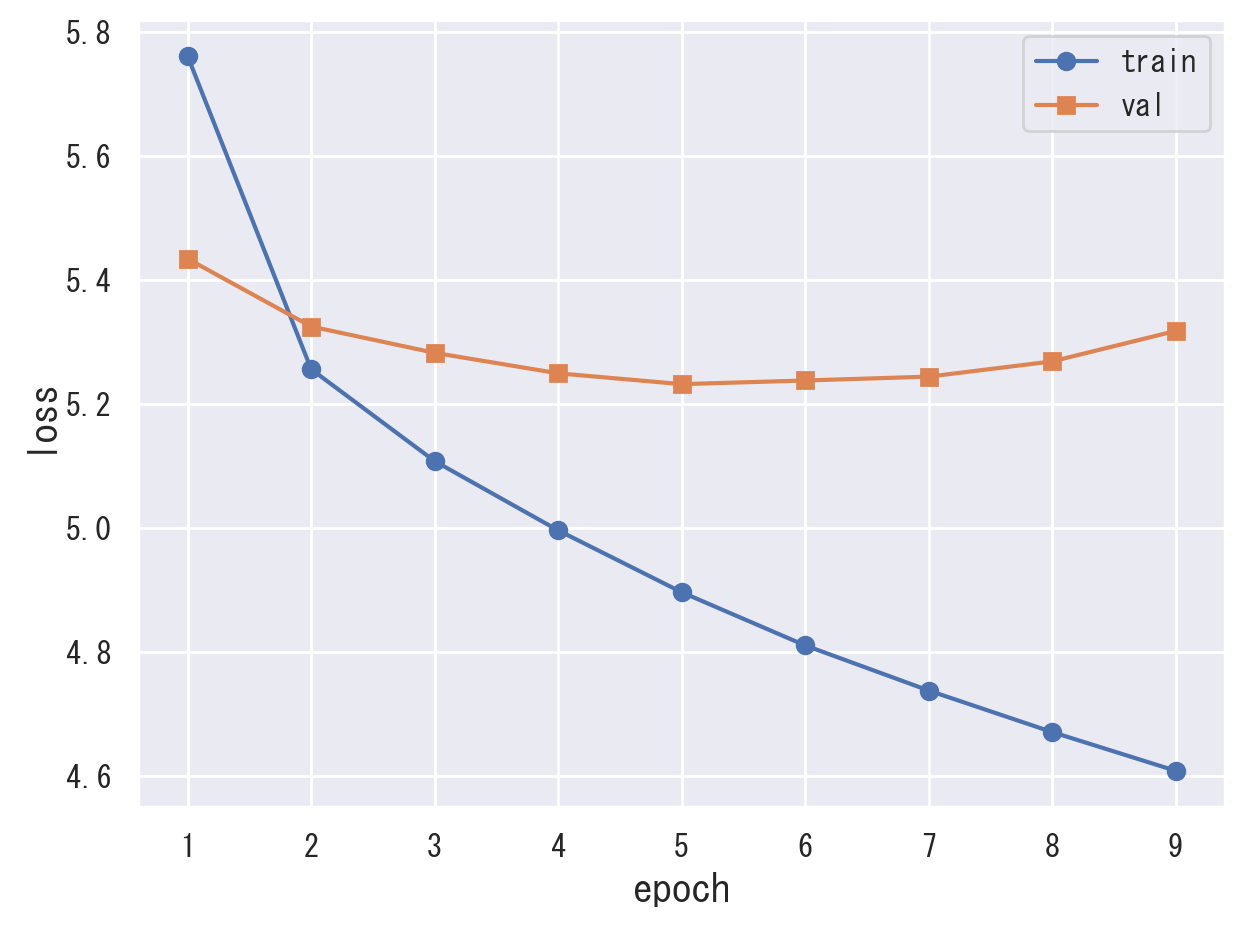

In [28]:
# 損失関数の可視化
actual_epoch = len(hist.history['loss'])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, actual_epoch+1), hist.history['loss'], marker='o', label='train')
ax.plot(range(1, actual_epoch+1), hist.history['val_loss'], marker='s', label='val')

ax.set_xlabel('epoch', fontsize=14)
ax.set_ylabel('loss', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

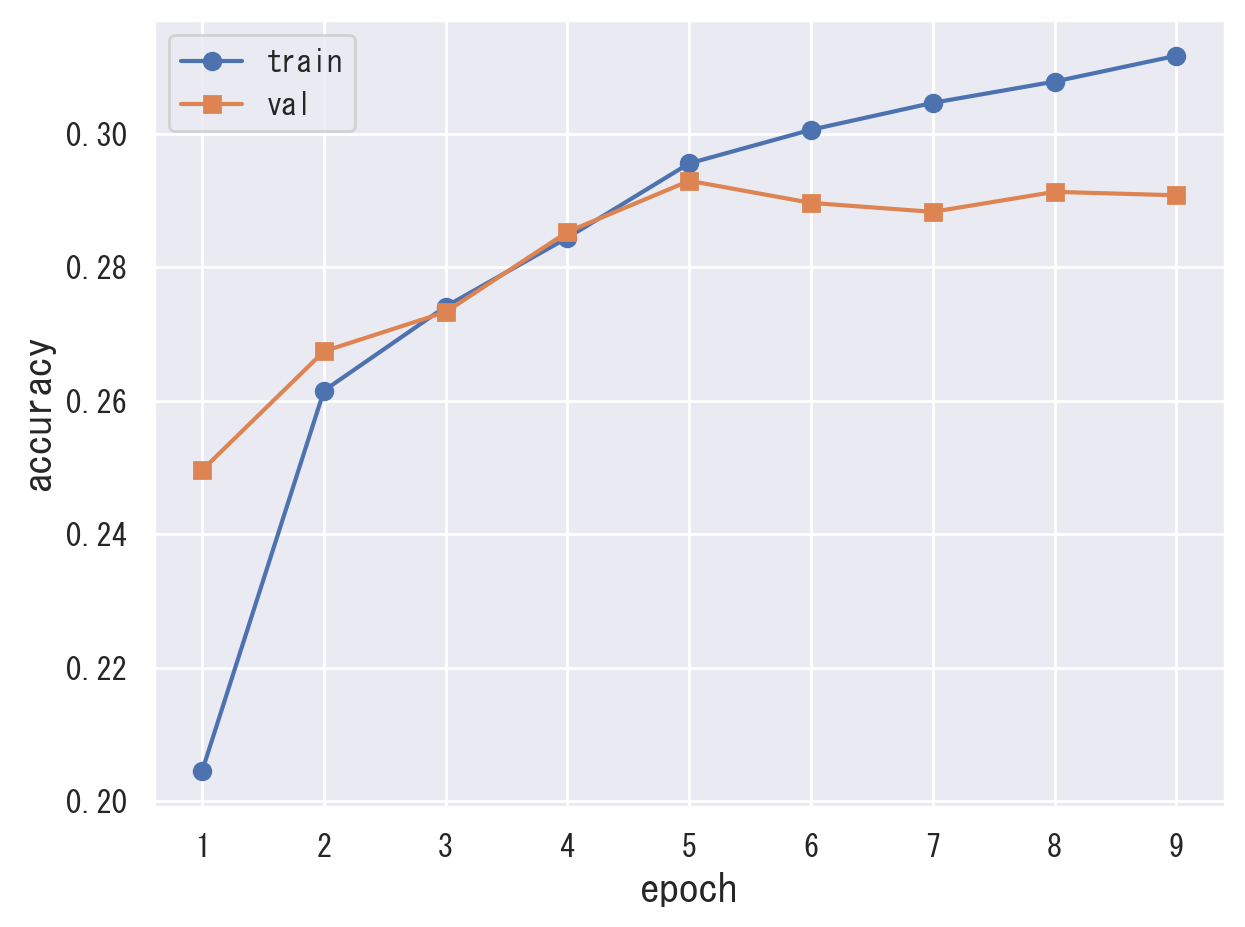

In [29]:
# 正解率の可視化
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(1, actual_epoch+1), hist.history['accuracy'], marker='o', label='train')
ax.plot(range(1, actual_epoch+1), hist.history['val_accuracy'], marker='s', label='val')

ax.set_xlabel('epoch', fontsize=14)
ax.set_ylabel('accuracy', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()